In [3]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import sys
import argparse
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import json
import pprint
import cv2
import os
import time

## 카카오 URL, 인증키

In [4]:
API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'
url = "https://kapi.kakao.com/v1/vision/product/detect"       
headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}

In [4]:
# 1. 사용할 이미지 설정

img_dir ='./data/style/casual44.jpg'                         # 학원컴퓨터
#img_dir ='C:/Jupyter_Script/img/test/test (103).jpg'            # 노트북

In [5]:
files = { 'file' : open(img_dir, 'rb')}
response = requests.post(url, headers=headers, files=files)
result = response.json()
fig_w, fig_h = result['result']['width'], result['result']['height']

[[0.34, 0.473333, 0.633333, 0.886667, 'pants'], [0.326667, 0.493333, 0.473333, 0.873333, 'shoes'], [0.26, 0.16, 0.706667, 0.733333, 'outer'], [0.493333, 0.88, 0.6, 0.986667, 'sports shoes']]
pants
shoes
outer
sports shoes


<function matplotlib.pyplot.show(*args, **kw)>

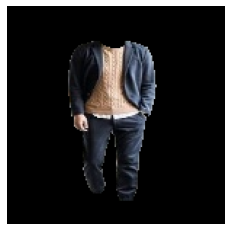

In [6]:
# 1) 사진 정보 담기
info = []
for each in result['result']['objects']:                 
    each = list(each.values())                       
    info.append(each)
print(info)
    
# 순서 : x1, y1, x2, y2, class
# 'class' key로 호출할 때, 여러 value(glasses, shoes 등) 포함됬었음
# 조건으로 pants, t-shirts 등 만 걸러내기 어려워서 이를 보안
    
    

# 2) 사진 잘라내기     
# 계속 새로운 이미지를 띄워줘야 앞에서 잘린 이미지로 계속 작업하지 않음
x_list = []
y_list = []
w_list = []
h_list = []
for _ in range(len(info)):
    image = Image.open(img_dir)
    
    img = cv2.imread('./data/style/casual44.jpg',1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    category = info[_][4]
    print(category)
    
    if category in ('shirts','t-shirts','pants','skirts','outer'):

        x = info[_][0]*fig_w #- 100
        y = info[_][1]*fig_h #- 100
        w = info[_][2]*fig_w #+ 50
        h = info[_][3]*fig_h #+ 50
        x_list.append(x)
        y_list.append(y)
        w_list.append(w)
        h_list.append(h)
x = int(min(x_list))
y = int(min(y_list))
w = int(max(w_list))
h = int(max(h_list))

mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
 
rect = (int(x),int(y),int(w),int(h)) # 범위 좌표
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
 
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
image_rbg_nobg = img_rgb * mask2[:,:,np.newaxis]

plt,imshow(image_rbg_nobg), plt.axis("off")
plt.show



In [11]:
save_dir = str('./data/nobg_style/')

for img_name in os.listdir('./data/style/'):
    try:    
        img_dir = './data/style/' + img_name
    
        img = cv2.imread(img_dir,1)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        files = { 'file' : open(img_dir, 'rb')}
        response = requests.post(url, headers=headers, files=files)
        result = response.json()
        fig_w, fig_h = result['result']['width'], result['result']['height']
    
        info = []
        for each in result['result']['objects']:                 
            each = list(each.values())                       
            info.append(each)
        
        x_list = []
        y_list = []
        w_list = []
        h_list = []
        
        category_list = []
        
        for _ in range(len(info)):
   
            category = info[_][4]
            category_list.append(category)
            if category in ('shirts','t-shirts','outer','pants','skirts','one-piece'):

                x = info[_][0]*fig_w #- 100
                y = info[_][1]*fig_h #- 100
                w = info[_][2]*fig_w #+ 50
                h = info[_][3]*fig_h #+ 50
                x_list.append(x)
                y_list.append(y)
                w_list.append(w)
                h_list.append(h)
                
                rect = (int(min(x_list)),int(min(y_list)),int(max(w_list)),int(max(h_list)))
                
            else:
                pass
        
        if category_list.isdisjoint(['one-piece']):
            if category_list.isdisjoint(['shirts','t-shirts','outer']) or category_list.isdisjoint(['pants','skirts']):
                rect = (5,5,150,150)
                
                

        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
 
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        image_rbg_nobg = img_rgb * mask2[:,:,np.newaxis]
        img = cv2.resize(image_rbg_nobg, (150,150))
    
        new_name = save_dir + img_name
        cv2.imwrite(new_name, img)
    except:
  
        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
 
        rect = (5,5,150,150)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
 
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        image_rbg_nobg = img_rgb * mask2[:,:,np.newaxis]
        img = cv2.resize(image_rbg_nobg, (150,150))
    
        new_name = save_dir + img_name
        cv2.imwrite(new_name, img)
    

